In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Set path
path = 'drive/MyDrive/SB_practical_notebooks/data/'
#path = 'drive/MyDrive/data/'

In [ ]:
!pip install biopython
!pip install scipy
!pip install matplotlib
!pip install biopython

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from Bio.PDB import PDBList, PDBParser
from Bio.SeqUtils import seq1

In [ ]:
!cp drive/MyDrive/SB_practical_notebooks/data/iupred_data.py .

In [ ]:
from iupred_data import aa_list, p_matrix, m_matrix

IUPRED ad-hoc implementation

In [ ]:
def iupred(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        # print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), i, start_before, end_before, start_after, end_after)

        # Count amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        # print(row)

        row = row / len(indices_local)  # calculate AA frequency
        # print(row)

        row = row * p_matrix[aa_index, ]  # calculate energy
        # print(row)

        aa_energy = np.sum(row)
        # print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

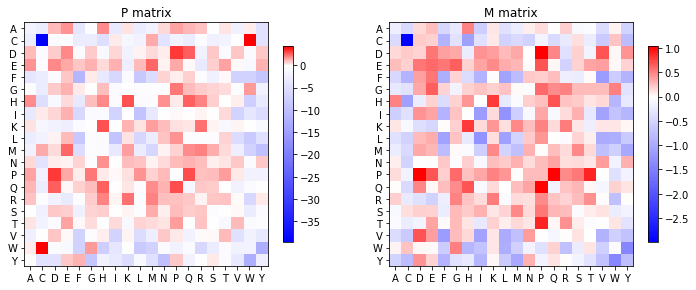

In [ ]:
p_matrix = np.array(p_matrix)
m_matrix = np.array(m_matrix)

# Plot the M and P matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
divnorm = colors.TwoSlopeNorm(vmin=np.amin(p_matrix), vcenter=0.,
                              vmax=np.amax(p_matrix))  # center the colormap (white) to 0
img = axes[0].imshow(p_matrix, interpolation="none", cmap='bwr', norm=divnorm)
axes[0].set_title('P matrix')
axes[0].set_xticks([i for i, aa in enumerate(aa_list)])
axes[0].set_xticklabels(aa_list)
axes[0].set_yticks([i for i, aa in enumerate(aa_list)])
axes[0].set_yticklabels(aa_list)
fig.colorbar(img, ax=axes[0], shrink=0.6)

divnorm = colors.TwoSlopeNorm(vmin=np.amin(m_matrix), vcenter=0.,
                              vmax=np.amax(m_matrix))  # center the colormap (white) to 0
img = axes[1].imshow(m_matrix, interpolation="none", cmap='bwr', norm=divnorm)
axes[1].set_title('M matrix')
axes[1].set_xticks([i for i, aa in enumerate(aa_list)])
axes[1].set_xticklabels(aa_list)
axes[1].set_yticks([i for i, aa in enumerate(aa_list)])
axes[1].set_yticklabels(aa_list)
fig.colorbar(img, ax=axes[1], shrink=0.6)

plt.savefig(path + 'iupred_matrix.png', bbox_inches='tight')

Structure exists: 'drive/MyDrive/SB_practical_notebooks/data/pdb1qjt.ent' 
1qjt A LSLTQLSSGNPVYEKYYRQVEAGNTGRVLALDAAAFLKKSGLPDLILGKIWDLADTDGKGVLSKQEFFVALRLVACAQNGLEVSLSSLSLAVPPPRFHD
Structure exists: 'drive/MyDrive/SB_practical_notebooks/data/pdb2lhk.ent' 
2lhk B MSIVSQTRNKELLDKKIRSEIEAIKKIIAEFDVVKESVNELSEKAKTDPQAAEKLNKLIEGYTYGEERKLYDSALSKIEKLIETLSPARSKSQSTMNQRNRNNRKIV


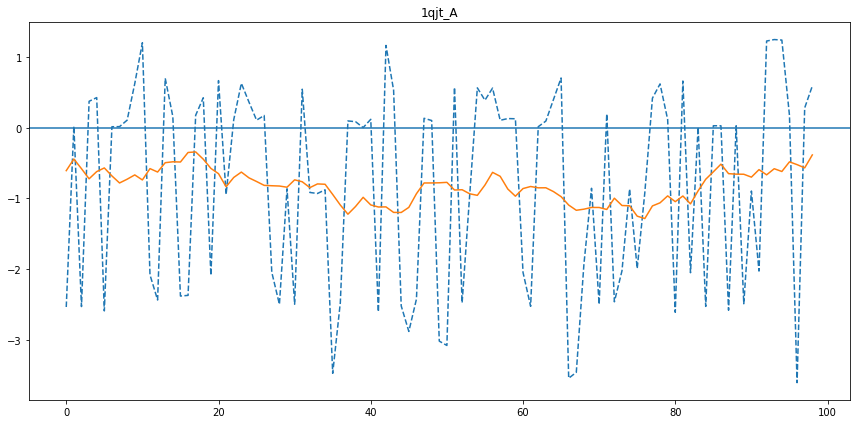

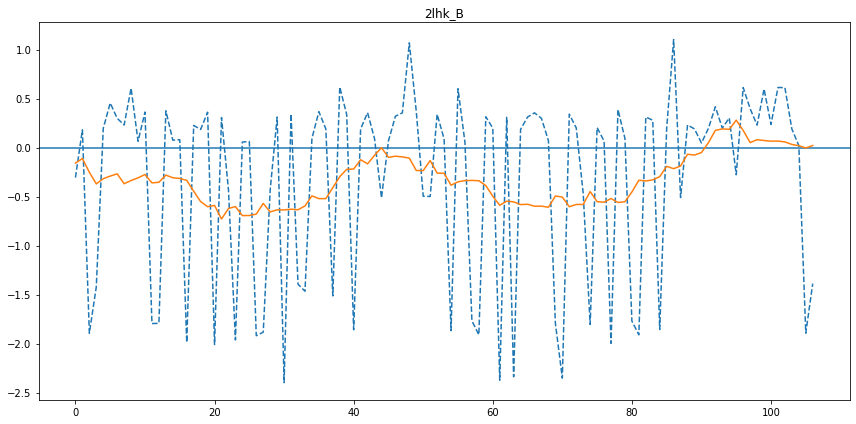

In [ ]:
# IUPRED prediction
pdb_ids = [('1qjt', 'A'), ('2lhk', 'B')]

pdbl = PDBList()
for pdb_id, chain_id in pdb_ids:

  pdbl.retrieve_pdb_file(pdb_id, pdir=path, file_format='pdb')
  structure = PDBParser(QUIET=True).get_structure(pdb_id, path + "pdb{}.ent".format(pdb_id))
  residues = [residue for residue in structure[0][chain_id] if residue.id[0] == " "]
  seq = "".join([seq1(residue.get_resname()) for residue in residues])
  print(pdb_id, chain_id, seq)

  fig, ax = plt.subplots(figsize=(12, 6))
  pred, pred_smooth = iupred(seq)  # prediction
  ax.set_title("{}_{}".format(pdb_id, chain_id))
  ax.axhline()
  ax.plot(np.arange(len(seq)), pred, ls='--')
  ax.plot(np.arange(len(seq)), pred_smooth, ls='-')

  plt.tight_layout()  # Remove figure padding
  plt.savefig(path + 'iupred_{}_{}.png'.format(pdb_id, chain_id), bbox_inches='tight')

MSDASLRSTSTMERLVARGTFPVLVRTSACRSLFGPVDHEELSRELQARLAELNAEDQNRWDYDFQQDMPLRGPGRLQWTEVDSDSVPAFYRETVQVGRCRLLLAPRPVAVAVAVSPPLEPAAESLDGLEEAPEQLPSVPVPAPASTPPPVPVLAPAPAPAPAPVAAPVAAPVAVAVLAPAPAPAPAPAPAPAPVAAPAPAPAPAPAPAPAPAPAPDAAPQESAEQGANQGQRGQEPLADQLHSGISGRPAAGTAAASANGAAIKKLSGPLISDFFAKRKRSAPEKSSGDVPAPCPSPSAAPGVGSVEQTPRKRLR


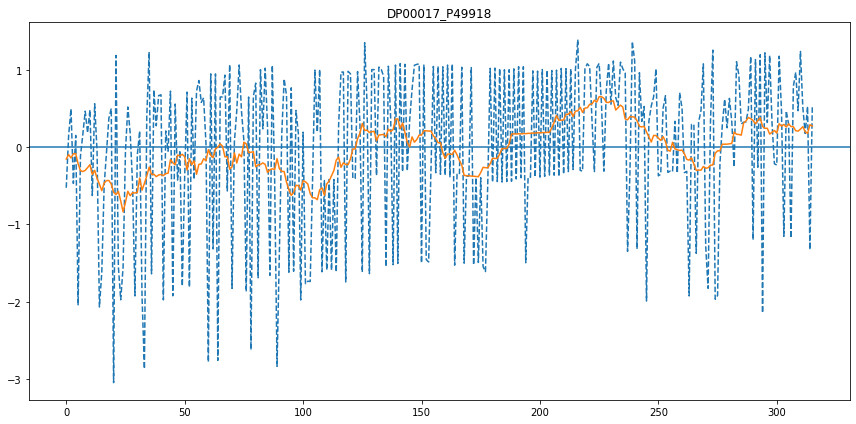

In [ ]:
seq = "MSDASLRSTSTMERLVARGTFPVLVRTSACRSLFGPVDHEELSRELQARLAELNAEDQNRWDYDFQQDMPLRGPGRLQWTEVDSDSVPAFYRETVQVGRCRLLLAPRPVAVAVAVSPPLEPAAESLDGLEEAPEQLPSVPVPAPASTPPPVPVLAPAPAPAPAPVAAPVAAPVAVAVLAPAPAPAPAPAPAPAPVAAPAPAPAPAPAPAPAPAPAPDAAPQESAEQGANQGQRGQEPLADQLHSGISGRPAAGTAAASANGAAIKKLSGPLISDFFAKRKRSAPEKSSGDVPAPCPSPSAAPGVGSVEQTPRKRLR"
print(seq)
pdb_id = "DP00017"
chain_id = "P49918"

fig, ax = plt.subplots(figsize=(12, 6))
pred, pred_smooth = iupred(seq)  # prediction
ax.set_title("{}_{}".format(pdb_id, chain_id))
ax.axhline()
ax.plot(np.arange(len(seq)), pred, ls='--')
ax.plot(np.arange(len(seq)), pred_smooth, ls='-')

plt.tight_layout()  # Remove figure padding
plt.savefig(path + 'iupred_{}_{}.png'.format(pdb_id, chain_id), bbox_inches='tight')